In [12]:
import os
import numpy as np
import pandas as pd
import torch
            

In [13]:

def generate_data( directory, window_size=75, step_size=32, pick_one=1, range=(0, 6)):
    from utilities import sliding_windows
    sw = sliding_windows(window_size, step_size)
    label_maps = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            if filename.split("_")[1] not in label_maps:
                label_maps.append(filename.split("_")[1])
    print(len(label_maps))
    assert pick_one < len(label_maps), "pick_one is out of range"
    save_data = []
    save_label = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            data = pd.read_csv(directory+filename)
            data_np = data.to_numpy()[:, range[0]:range[1]]
            if pick_one >= 0:
                if filename.split("_")[1] != label_maps[pick_one]:
                    cls = 0
                else:
                    cls = 1
            else:
                cls = label_maps.index(filename.split("_")[1])
            label = np.array([cls] * data_np.shape[0])
            data_windows, label_windows = sw.forward(torch.tensor(data_np), labels=torch.tensor(label))
            save_data.append(data_windows)
            save_label.append(label_windows)
    save_data = torch.cat(save_data)
    save_label = torch.cat(save_label)
    return save_data, save_label
            
            
            

In [9]:
# custom Dataset:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx]), self.label[idx]
        return self.data[idx], self.label[idx]

In [10]:
from utils_loader import MultiEpochsDataLoader
from sklearn.discriminant_analysis import StandardScaler
import torch
from utilities import seed

class StandardTransform(torch.nn.Module):
    def __init__(self, scaler='standard'):
        super(StandardTransform, self).__init__()
        if scaler == 'standard':
            self.scaler = StandardScaler()
        else:
            raise NotImplementedError('Only standard scaler is implemented')
        
    def __call__(self, data):
        data = self.scaler.transform(data)
        return torch.tensor(data)
    
    def fit(self, data):
        n_samples, n_time_steps, n_features = data.shape
        data_reshaped = data.reshape(-1, n_features)  # The shape becomes (n_samples * n_time_steps, n_features)
        self.scaler.fit(data_reshaped)
        print('Fitted with mean: {}, and std: {}'.format(self.scaler.mean_, np.sqrt(self.scaler.var_)))
        return self
    

seed(73054772)
directory = './raw_datasets/SPAR/'

# create train, val, test dataset:
segmented_samples, segmented_labels = generate_data(directory, window_size=100, step_size=50, pick_one=-1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(segmented_samples, segmented_labels, test_size=0.3, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

d, l = next(iter(train_loader))

7


In [1]:
from segmenter import Segmenter
from utilities import get_device
device = get_device()

MPS is available.


In [6]:
def mean_iou_time_series(pred, gt, num_classes=7):
    """
    Calculate the Mean Intersection over Union (mIoU) for time series data.
    
    Parameters:
        pred (torch.Tensor): Predictions, assumed to be one-hot encoded.
        gt (torch.Tensor): Ground truth labels, assumed to be one-hot encoded.
        num_classes (int): Number of classes in the segmentation task.

    Returns:
        float: Mean IoU for the batch.
    """
    # Initialize variables to store IoU for each class
    iou_list = []

    # Loop through each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        gt_inds = gt == cls

        # Calculate Intersection and Union
        # print(pred_inds.shape, gt_inds.shape)
        intersection = torch.sum(pred_inds & gt_inds, dim=1).float()
        union = torch.sum(pred_inds | gt_inds, dim=1).float()

        # Calculate IoU. Avoid division by zero by adding a small epsilon.
        iou = intersection / (union + 1e-8)

        # Append the mean IoU for this class
        iou_list.append(torch.mean(iou))

    # Calculate the mean IoU across all classes
    mean_iou = torch.mean(torch.stack(iou_list))

    return mean_iou.item()


def mean_iou(preds, labels, num_classes):
    # Flatten the predictions and labels, this comes from the argmax of the one-hot vectors
    preds = preds.view(-1)
    labels = labels.view(-1)

    # Create confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for i in range(num_classes):
        for j in range(num_classes):
            confusion_matrix[i, j] = torch.sum((preds == i) & (labels == j))

    # Calculate IoU for each class
    ious = []
    for i in range(num_classes):
        true_positive = confusion_matrix[i, i]
        false_positive = confusion_matrix[i, :].sum() - true_positive
        false_negative = confusion_matrix[:, i].sum() - true_positive

        # Avoid division by zero
        union = true_positive + false_positive + false_negative
        if union == 0:
            ious.append(float('nan'))  # No predictions and no labels for this class
        else:
            ious.append(true_positive.float() / union.float())

    # Calculate mean IoU
    ious = torch.tensor(ious)
    mean_iou = torch.nanmean(ious)  # Mean over all classes, ignoring NaNs
    return mean_iou


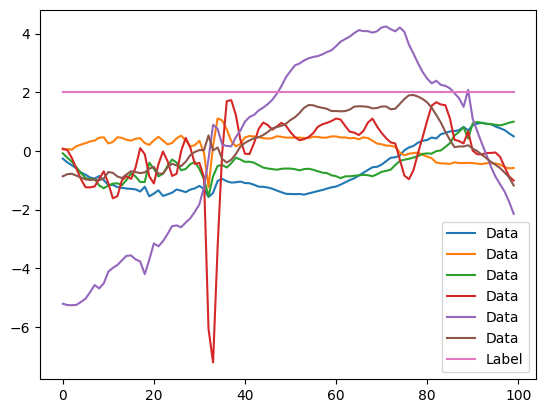

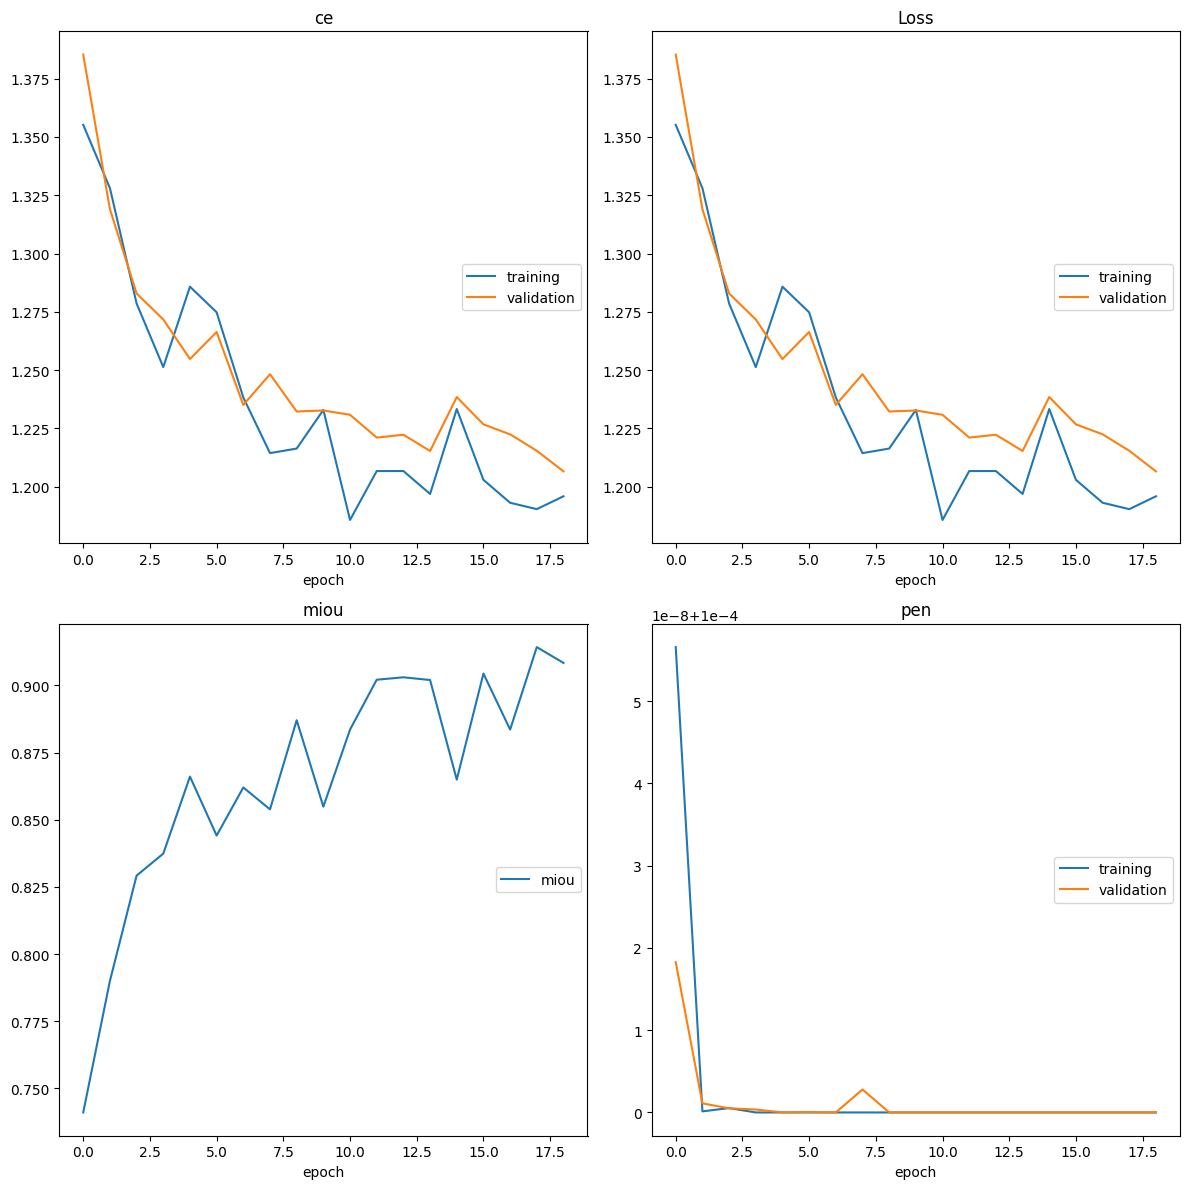

ce
	training         	 (min:    1.186, max:    1.355, cur:    1.196)
	validation       	 (min:    1.207, max:    1.385, cur:    1.207)
Loss
	training         	 (min:    1.186, max:    1.355, cur:    1.196)
	validation       	 (min:    1.207, max:    1.385, cur:    1.207)
miou
	miou             	 (min:    0.741, max:    0.914, cur:    0.908)
pen
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [9]:
# Create an instance of the CNN model
from livelossplot import PlotLosses
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from utilities import get_device
num_epochs = 100 
def c_loss(logits):
    probabilities = F.softmax(logits, dim=1)
    one_hot_predictions = torch.argmax(probabilities, dim=1)
    product_prob = torch.prod(probabilities, dim=1)
    changes = torch.abs(one_hot_predictions[:, 1:]*product_prob[:, 1:] - one_hot_predictions[:, :-1]*product_prob[:, :-1])
    penalty = changes.sum(dim=1).float().mean()
    return penalty + 1e-4
def custom_loss(logits, targets, penalty_weight=0.1):
    """
    Custom loss function that penalizes frequent changes in the prediction sequence.
    
    Args:
    - logits: Tensor of shape [N, C, L], where N is batch size, C is number of classes, and L is sequence length.
    - targets: Tensor of shape [N, L] containing class indices for each element in the sequence.
    - penalty_weight: Weight of the penalty term.

    Returns:
    - Total loss with the penalty.
    """

    # Standard cross-entropy loss
    probabilities = F.softmax(logits, dim=1)
    ce_loss = F.cross_entropy(probabilities, targets)

    penalty = c_loss(logits)
    total_loss = ce_loss #penalty * penalty_weight

    return total_loss, ce_loss.item(), penalty.item()

def plotASample(data, label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)  # Add a new subplot to the figure
    ax.plot(data, label='Data')  # Plot the data
    ax.plot(label, label='Label')  # Plot the label
    ax.legend()  # Add a legend
    fig.canvas.draw()  # Redraw the figure
    plt.plot()


model = Segmenter().to(device)

# Define the loss function and optimizer
criterion =custom_loss #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00)
liveloss = PlotLosses()

# Iterate over the training data
logs = {}
# change the plt size:
best_loss = math.inf
counter_i = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs.permute(0, 2, 1)
        loss, tra_ce, tra_pen = criterion(outputs, labels.long())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train loss and accuracy check:
        if counter_i % 1000 == 0 and counter_i != 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            _, predicted = torch.max(outputs.data, 1)
            # total = labels.size(0)
            # correct = (predicted == labels).sum().item()
            # print('Accuracy: {:.2f}%'.format(correct / total * 100))
            logs['loss'] = loss.item()
            logs['ce'] = tra_ce
            logs['pen'] = tra_pen
            # logs['accuracy'] = correct / total * 100
    
            # validation loss and accuracy check:
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.float().to(device)
                labels = labels.to(device)
                outputs = model(images)
                outputs = outputs.permute(0, 2, 1) #view(images.shape[0], 2, -1)
                loss, val_ce, val_pen = criterion(outputs, labels.long())
            logs['val_loss'] = loss.item()
            logs['val_ce'] = val_ce
            logs['val_pen'] = val_pen
            logs['miou'] = mean_iou(model.forward_pred(images), labels.long(), num_classes=7)
            if best_loss > loss.item():
                best_loss = loss.item()
                torch.save(model.state_dict(), './saved_model/best_transformer_spar.pth')
            pred = torch.argmax(torch.softmax(outputs[0], dim=0), dim=0).detach().cpu().numpy()
            plotASample(images[0].detach().cpu().numpy(), pred)
            liveloss.update(logs)
            liveloss.send()
            # logs['val_accuracy'] = correct / total * 100
        counter_i += 1


In [7]:
import time
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import torch


model = Segmenter().to(device)
model.load_state_dict(torch.load('./saved_model/best_transformer_spar.pth', map_location=device))

model.eval()
miou, total = 0, 0
with torch.no_grad():
    for data, label in test_loader:
        data = data.float().to(device)
        label = label.squeeze().long().to(device)
        output = model.forward_pred(data)
        # print(output.shape, label.shape)
        # print(output[0], label[0])
        miou += mean_iou(output, label, 7)
        total += 1
        
        # print('output', output)])
        # plt.plot(data[0].view(-1, 6).cpu().numpy(), color='black')
        # plt.plot(output[0].view(-1).detach().squeeze().cpu().numpy(), color='green')
        # plt.plot(label[0].view(-1).cpu().numpy(), color='red')
        # plt.show()
        # # wait for 1 sec:
        # time.sleep(1)
        # erase the output:
        # clear_output(wait=True)

print('mIoU coefficient:', miou / total)

mIoU coefficient: tensor(0.1303)


In [ ]:
# few show learning on a new dataset:
directory = './datasets/physiq_copy/segment_sessions_one_repetition_data_E2'
combo = ['1', '2']
num_results = 1  # Number of random combinations to generate
files = list_files(directory)
groups = group_files(files)
# randomly pick one group from the dic:
key = random.choice(list(groups.keys()))
group = groups[key]
combinations,labels = generate_combinations(group, combo, num_results)
# print(combinations)


segmented_samples = []
segmented_labels = []
for i, (order, label) in enumerate(zip(combinations, labels)):
    print('length', len(order), order, label)
    concatenated_np, concat_label = concatenate_data(directory, group, order, label=label)
    
    conc_data = torch.tensor(concatenated_np)
    conc_label = torch.tensor(concat_label)
    
    segmented_sample, segmneted_label  = sw.forward(conc_data, conc_label)
    segmented_samples.append(segmented_sample)
    segmented_labels.append(segmneted_label)

segmented_samples = torch.cat(segmented_samples)
segmented_labels = torch.cat(segmented_labels)
support_Size = len(segmented_labels)
# change it to be dataset
dl = DataLoader(CustomDataset(segmented_samples, segmented_labels), batch_size=5, shuffle=False)

NameError: name 'list_files' is not defined

In [ ]:
# few show learning on a new dataset:
directory = './datasets/physiq_copy/segment_sessions_one_repetition_data_E2'
combo = ['1', '2']
num_results = 1  # Number of random combinations to generate
files = list_files(directory)
groups = group_files(files)
# randomly pick one group from the dic:
key = random.choice(list(groups.keys()))
group = groups[key]
combinations,labels = generate_combinations(group, combo, num_results)
# print(combinations)


segmented_samples = []
segmented_labels = []
for i, (order, label) in enumerate(zip(combinations, labels)):
    print('length', len(order), order, label)
    concatenated_np, concat_label = concatenate_data(directory, group, order, label=label)
    
    conc_data = torch.tensor(concatenated_np)
    conc_label = torch.tensor(concat_label)
    
    segmented_sample, segmneted_label  = sw.forward(conc_data, conc_label)
    segmented_samples.append(segmented_sample)
    segmented_labels.append(segmneted_label)

segmented_samples = torch.cat(segmented_samples)
segmented_labels = torch.cat(segmented_labels)

# change it to be dataset
test_dl = DataLoader(CustomDataset(segmented_samples, segmented_labels), batch_size=5, shuffle=False)

length 7 ['1', '1', '0', '1', '2', '1', '1'] [0, 0, 0, 1, 1, 0, 0]


In [ ]:
def cosine_distance_to_prototypes(A, B) -> torch.Tensor:
    """
    Compute prediction logits from their cosine distance to support set prototypes.
    Args:
        samples: features of the items to classify of shape (n_samples, feature_dimension)
    Returns:
        prediction logits of shape (n_samples, n_classes)
    """
    return torch.nn.functional.normalize(A, p=2, dim=1) @ torch.nn.functional.normalize(B, p=2, dim=1).T

def get_logits(features: torch.tensor, prototype, temperature=0.1) -> torch.tensor:

    """
    Computes the cosine similarity between self.prototype and given features
    inputs:
        features : shape [n_tasks, shot, c, h]

    returns :
        logits : shape [n_tasks, shot, h]
    """

    # Put prototypes and features in the right shape for multiplication
    features = features.permute((0, 1, 3, 2))  # [n_task, shot, h, c]
    print('features should n=N, shot=1, h=100, c=64', features.shape)
    prototype = prototype.unsqueeze(1).unsqueeze(2)  # [n_tasks, 1, 1, c]
    print('prototype = [n_tasks, 1, 1, c]', prototype.shape)
    print(prototype.shape)
    # Compute cosine similarity
    cossim = features.matmul(prototype.unsqueeze(3)).squeeze(3) # [n_task, shot, h=100, w]
    cossim /= ((prototype.unsqueeze(3).norm(dim=4) * \
                features.norm(dim=4)) + 1e-10)  # [n_tasks, shot, h, w]

    return temperature * cossim
    
def init_prototypes(features_s, features_q, support_labels, n_task=2, c=1):
    """
        inputs:
            n_task = N, shot = 1, c is the hidden feature (channel) = 64, h = 100
            features_s : shape [n_task, shot, c, h]
            features_q : shape [n_task, 1, c, h]
            gt_s : shape [n_task, shot, H]
            gt_q : shape [n_task, 1, H]

        returns :
            prototypes : shape [n_task, c]
            bias : shape [n_task]
    """
    # Computing prototypes
    fg_mask = (support_labels == 1)
    fg_mask = fg_mask.unsqueeze(1) # [n_task, shot=1, 100]
    print("fg_mask", fg_mask.shape)
    print("features_s", features_s.shape)
    fg_prototype = (features_s * fg_mask).sum(dim=1)
    fg_prototype /= (fg_mask.sum(dim=1) + 1e-10)  # [n_task, c]

    prototype = fg_prototype
    print('features_q, [n_tasks, 1, c, h]',features_q.shape)
    features_q = features_q.unsqueeze(1)  # [n_tasks, 1, c, h]
    logits_q = get_logits(features_q, prototype)  # [n_tasks, shot, h]
    bias = logits_q.mean(dim=(1, 2))

    assert prototype.size() == (n_task, c), prototype.size()
    assert torch.isnan(prototype).sum() == 0, prototype
    return 
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        
    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        z_support = z_support.permute(0, 2, 1 )
        z_query = z_query.permute(0, 2, 1 )
        print(z_support.shape, z_query.shape, support_labels.shape)
        init_prototypes(z_support, z_query, support_labels)
        
    
    

In [ ]:
model.decoder = nn.Identity()
prototype_model = PrototypicalNetworks(model).to(device)

In [ ]:
sample = next(iter(dl))
test_sample = next(iter(test_dl))
print(sample[0].shape)
print(test_sample[0].shape)
z = prototype_model.forward(sample[0].float().to(device), sample[1].float().to(device), test_sample[0].float().to(device))
# z.shape

torch.Size([5, 75, 6])
torch.Size([5, 75, 6])
torch.Size([5, 64, 75]) torch.Size([5, 64, 75]) torch.Size([5, 75])
fg_mask torch.Size([5, 1, 75])
features_s torch.Size([5, 64, 75])
features_q, [n_tasks, 1, c, h] torch.Size([5, 64, 75])
features should n=N, shot=1, h=100, c=64 torch.Size([5, 1, 75, 64])
prototype = [n_tasks, 1, 1, c] torch.Size([5, 1, 1, 75])
torch.Size([5, 1, 1, 75])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [25, 64] but got: [25, 1].